In [25]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import glob
import os
from flashtext import KeywordProcessor
from typing import *
import re

In [26]:
# pathprefix = r"D:\Code Working Area\Jupyter\knowledge-graph-for-stakeholder-risks-detection-in-mega-infrastructure-projects\ExcelData"
# jsfile = pathprefix+"\\Transactions.json"
# stop_words=pathprefix+"\\stop_words\\stop_words_stakeholder.txt"
# unknow_long_phrase=pathprefix+"\\stop_words\\unknow_long.txt"

# project_sor = pathprefix+"\\Source\\project.csv"
# risk_sor = pathprefix+"\\Source\\risk.xlsx"
# stake_sor = pathprefix+"\\Source\\stakeholder.csv"

# project_key = pathprefix+"\\project_keyword\\Project_keyword.xlsx"
# risk_key_path = pathprefix+"\\risk_keyword\\Risk_keyword.xlsx"
# stake_key = pathprefix+"\\stakeholder_keyword\\third_layer_iteration_one_stakeholder.xlsx"

In [27]:
# prj_key = pd.read_excel(project_key, index_col=None)
# risk_key = pd.read_excel(risk_key_path, index_col=None)
# stk_key = pd.read_excel(stake_key, index_col=None)
# stk_key.dropna(inplace=True)
# stk_key.Abstract = stk_key.Abstract.str.lower()

# # Do I really need below two steps?
# risk_key.Abstract=risk_key.Abstract.astype(str)
# stk_key.Abstract=stk_key.Abstract.astype(str)
keywords = pd.read_csv(r"../LLama_result_clean/Generated_Result/three_output1.csv", sep=";").fillna("Yes")
stupid_copy = {col: [val for val in keywords[col].str.split("|", expand=True).stack().dropna()]\
           for col in ["Project", "Risk", "Stakeholder"]}
prj_key, stk_key, risk_key = stupid_copy["Project"], stupid_copy["Stakeholder"], stupid_copy["Risk"]

In [28]:
def myFunc(val: List[str]):
    pattern = r'\b(?:yes|Yes)\b'
    processed_list = [item for item in val if not re.search(pattern, item)]
    return processed_list

prj_key, stk_key, risk_key = myFunc(prj_key), myFunc(stk_key), myFunc(risk_key)

In [29]:
# test running process
prjkeyword, stkeyw, riskeyw = KeywordProcessor(), KeywordProcessor(), KeywordProcessor()
prjkeyword.add_keywords_from_list(prj_key)
stkeyw.add_keywords_from_list(stk_key)
riskeyw.add_keywords_from_list(risk_key)


def single_plot(left: KeywordProcessor, val: list):
    existence: int = 0
    for keyword in val:
        if left.extract_keywords(keyword): existence += 1
    return existence


def row_retrieve(name: str, left: KeywordProcessor, comparison: pd.DataFrame):
    extradata: list = []
    for val in comparison.iterrows():
        ori, dest = val[1][0:2]
        ori, dest = ori.split(", "), dest.split(", ")
        ori, dest = single_plot(left, ori), single_plot(left, dest)
        extradata.append([ori, dest])
    comparison[[name + " on start", name + " on destination"]] = pd.DataFrame(extradata)
    return comparison

In [30]:
def test_retrieve(test_file: pd.DataFrame):
    temp=row_retrieve("prj", prjkeyword, test_file)
    temp=row_retrieve("stk", stkeyw, temp)
    return row_retrieve("risk", riskeyw, temp)

In [31]:
prefixpath = r"../LLama_result_clean/Generated_Result/1k_fp.csv"
fp_qualified=pd.read_csv(prefixpath, sep=";")
# csv_files = glob.glob(os.path.join(prefixpath, "*.csv"))
# fpresult: list[pd.DataFrame] = []
# for files in csv_files[:17]:
#     if pd.read_csv(files, sep=",").shape[1]!=3: continue
#     fpresult.append(pd.read_csv(files, sep=",").replace(regex=["{", "}", "'"], value=""))
# fp_qualified = pd.concat(fpresult, ignore_index=True, axis=0)

In [39]:
# fp_tag=test_retrieve(fp_qualified)
# fp_tag
(len(prj_key)+len(risk_key)+len(stk_key))*0.0012

3.4031999999999996

In [33]:
def general_info_judge(dataset: pd.Series):
    series = dataset.to_list()[3:]
    len3 = True if series[0] + series[1] > 0 and series[2] + series[3] > 0 and series[4] + series[5] > 0 else False
    len2 = True if sum(
        [1 if series[i] + series[j] > 0 else 0 for i in [0, 2, 4] for j in [1, 3, 5] if i == j - 1]) == 3 else False
    return True if len2 or len3 else False


fp_mask = fp_tag.apply(lambda x: general_info_judge(x), axis=1)
fp_qualified = fp_qualified[fp_mask]
fp_qualified = fp_qualified.loc[:, fp_qualified.columns[:3]].reset_index(drop=True)

In [34]:
fp_qualified

,Start,to,confidence ratio
0,Limited lifetime of fossil investments due to ...,Energy infrastructure projects (EU support for...,1.000000
1,Energy infrastructure projects (EU support for...,Limited lifetime of fossil investments due to ...,1.000000
2,Project sponsors,Energy infrastructure projects (EU support for...,1.000000
3,Energy infrastructure projects (EU support for...,Project sponsors,1.000000
4,Energy infrastructure projects (EU support for...,Limited lifetime of fossil investments due to ...,1.000000
...,...,...,...
3997,Construction,Management,0.500000
3998,Management,Construction,0.500000
3999,Construction project,contractors,0.333333
4000,contractors,Construction project,0.166667


## Direct Reading From Cleaned File TO Generate Graph

In [22]:
# dataset=pd.read_excel(prefixpath+"\\drawing.xlsx")
dataset=fp_qualified
def cleanw(args:str):
    args=args[2:-2]
    args=args.replace("'", "")
    return args

In [23]:
mask=dataset.possibility.apply(lambda x: x >= 0.5 and x <= 0.97)
new_set=dataset[mask].drop_duplicates(subset=["start", "to"]).reset_index(drop=True)
new_set

,start,to,possibility
0,fair risk,pfi,0.800000
1,weiss,phase project,0.800000
2,hl,water project,0.666667
3,fra,flood risk,0.666667
4,fra,"hec, flood risk",0.666667
...,...,...,...
16757,"Operational risk, Economic risk",Reputation risk,0.684211
16758,"Economic risk, Reputation risk",Environmental risk,0.769231
16759,"Flood risk, Economic risk",Environmental risk,0.769231
16760,Economic risk,Environmental risk,0.775934


In [24]:
graph=nx.DiGraph()
for index, row in new_set.loc[:, ].iterrows(): graph.add_edge(row["start"], row["to"], weight=row["possibility"])
pos=nx.spring_layout(graph, k=0.5)

KeyboardInterrupt: 

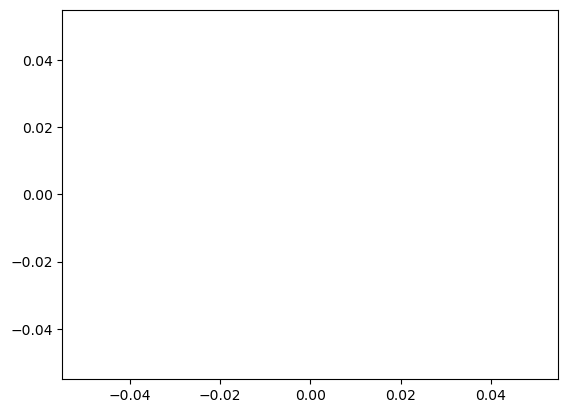

In [38]:
nv=list({*new_set.start.to_list(), *new_set.to.to_list()})

def article_type(node: str):
    if len(node.split(", "))>1: return "hybrid"
    if stk_key.Abstract.str.contains(node).any().any():
        return "stk"
    elif risk_key.Abstract.str.contains(node).any().any():
        return "risk"
    elif prj_key.Article.str.contains(node).any().any():
        return "prj"
    else: return "unknow"

def shape_and_color()-> tuple[list[str], list[str]]:
    node_shape, node_color=[], []
    for node in graph.nodes():
        if article_type(node)=="risk":
            node_color.append("#60F7A7")
            node_shape.append("o")
        elif article_type(node)=="stk":
            node_color.append("#E374FF")
            node_shape.append("v")
        elif article_type(node)=="prj":
            node_color.append("#D7FF09")
            node_shape.append("d")
        elif article_type(node)=="hybrid":
            node_color.append("#FF5309")
            node_shape.append("h")
        elif article_type(node)=="unknow":
            node_color.append("#2109FF")
            node_shape.append("s")
    return node_shape, node_color

lengend_label=["risk", "stakeholder", "project", "hybrid task", "unknow task"]
lengend_plot=[plt.plot([], [], marker="o", markersize=10, color="#60F7A7", label="risk")[0],
              plt.plot([], [], marker="o", markersize=10, color="#E374FF", label="stakeholder")[0],
              plt.plot([], [], marker="o", markersize=10, color="#D7FF09", label="project")[0],
              plt.plot([], [], marker="o", markersize=10, color="#FF5309", label="hybrid task")[0],
              plt.plot([], [], marker="o", markersize=10, color="#2109FF", label="unknow task")[0]]

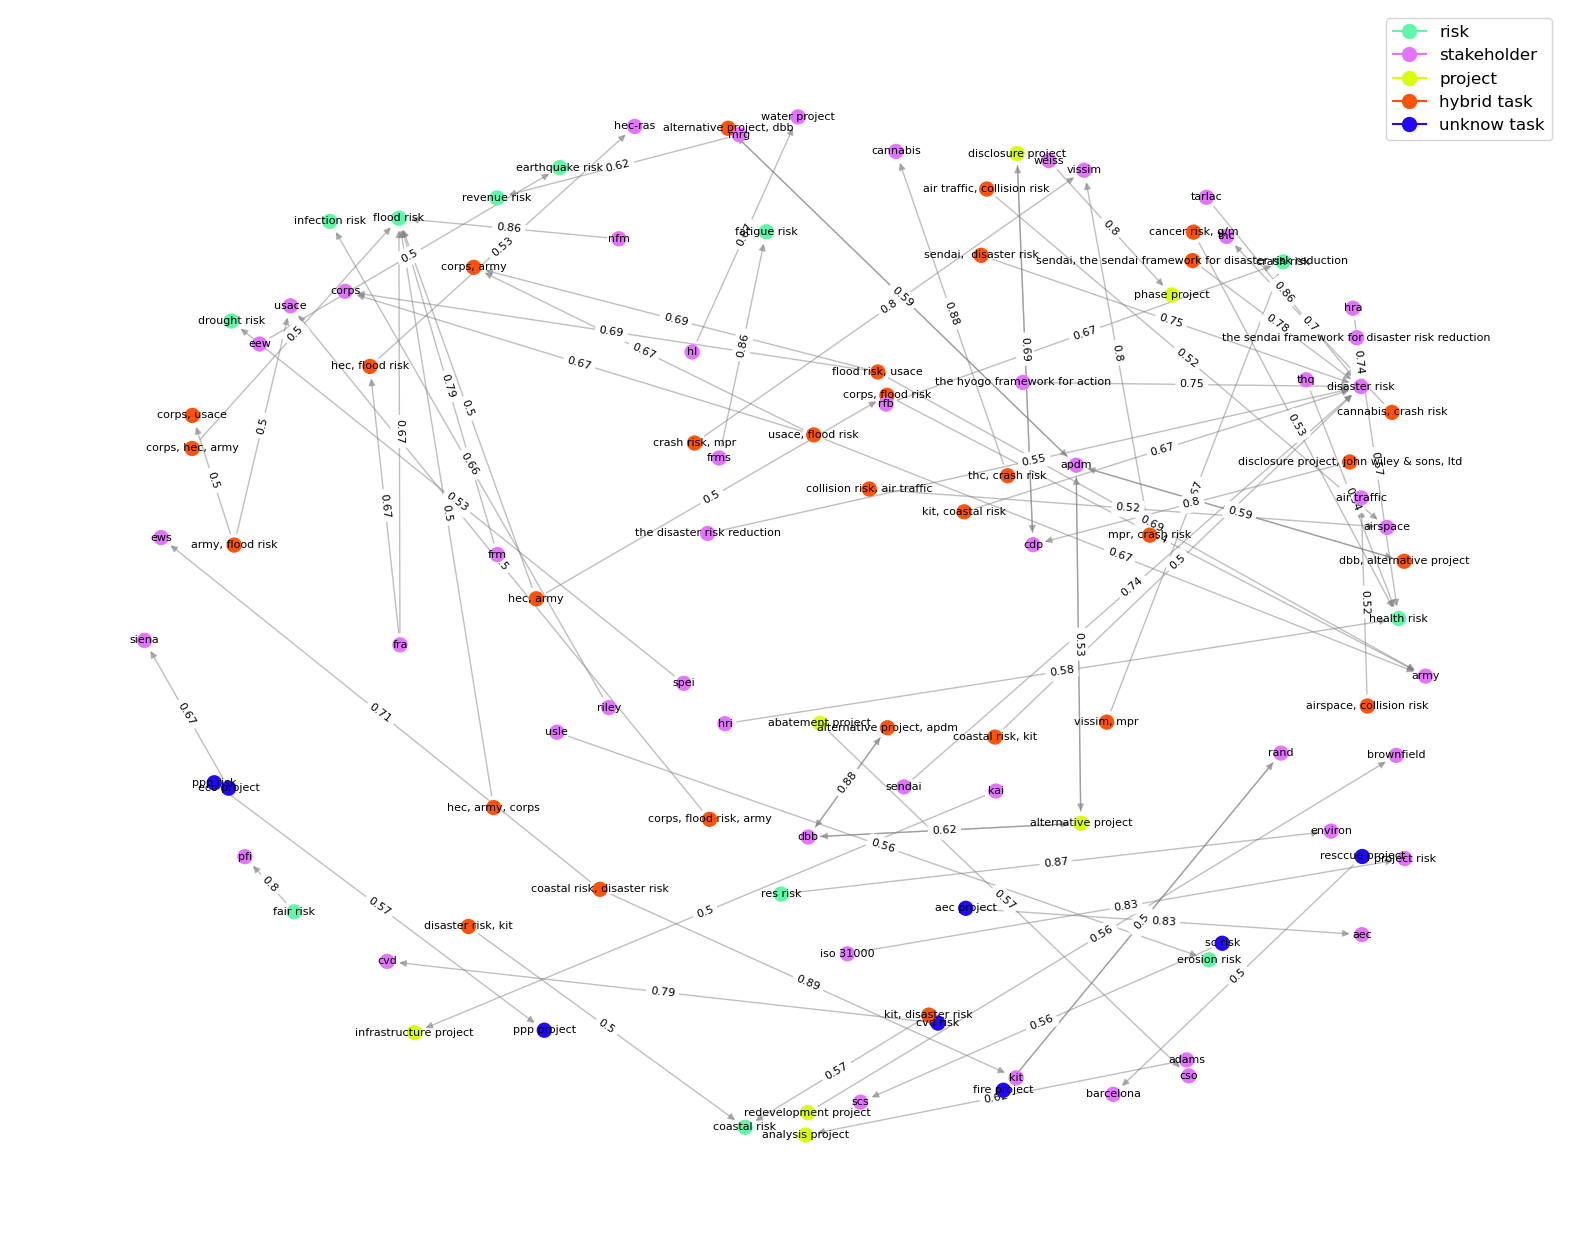

In [39]:
edge_labels = {(u, v): round(d['weight'], 2) for u, v, d in graph.edges(data=True)}
node_shapes, node_colors=shape_and_color()
# Drawing the graph
nx.draw_networkx_nodes(graph, pos, node_size=100, node_color=node_colors)
nx.draw_networkx_edges(graph, pos, edge_color='gray', alpha=0.5)
nx.draw_networkx_labels(graph, pos, font_size=8, font_family='sans-serif')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8, font_family='sans-serif')

# Displaying the plot
fig=plt.gcf()
fig.set_size_inches(20, 16)
# plt.figure(figsize=(20, 20))
plt.axis('off')
plt.legend(handles=lengend_plot, loc="best", fontsize=12)
plt.show()

In [ ]:
G = nx.from_pandas_edgelist(new_set, source='start', target='to', edge_attr='probability', create_using=nx.DiGraph())

# Define your labels and colors
labels = ["risk", "stakeholder", "project", "hybrid task", "unknown task"]
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Add node attributes for the labels
for node in G.nodes:
    for i, label in enumerate(labels):
        if label in node:
            G.nodes[node]['label'] = label
            G.nodes[node]['color'] = colors[i]
            break

# Draw the graph with custom node colors based on the labels
pos = nx.spring_layout(G)
node_colors = [G.nodes[node]['color'] for node in G.nodes]
nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=1000, alpha=0.8, font_size=10)

# Create the legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
                   for label, color in zip(labels, colors)]
plt.legend(handles=legend_elements, loc='best')

# Show the plot
plt.show()

TypeError: 'Line2D' object is not subscriptable

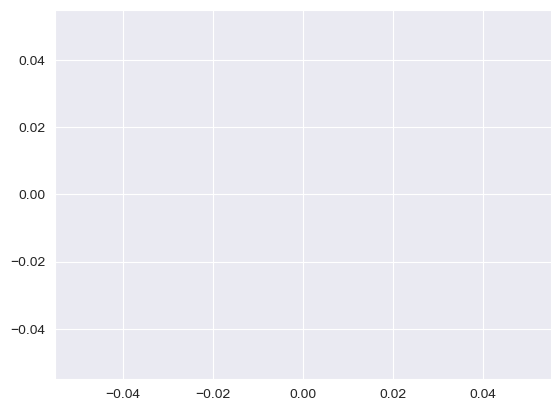

In [112]:
plt.plot([], [], marker="o", markersize=10, color="#60F7A7", label="risk")[0]